# Music Genre Classification using DNNs               

### Details
Project members:
1. Siva Kiran Mallidi : 210002051
2. Sajan Swaroop Reddy: 210002008
3. Subash Ganti       : 210002032

## Importing necessary packages

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import scipy 
import sys 
import os 
import pickle 
import librosa 
import librosa.display
from IPython.display import Audio 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf 
from tensorflow import keras as k
import csv

# Feature Extraction from dataset

We will extract
* Mel-frequency cepstral coefficients (MFCC) (20 in number)
* Spectral Centroid
* Zero Crossing Rate
* Chroma Frequencies
* Spectral Roll-off

In [5]:
header = 'filename chroma_stft_mean chroma_stft_var rms_mean rms_var spectral_centroid_mean spectral_centroid_var spectral_bandwidth_mean spectral_bandwidth_var rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var temp'
for i in range(1, 21):
    header += f' mfcc{i}_mean mfcc{i}_var '
header += ' label'
header = header.split()

In [4]:
file = open('/kaggle/working/data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/{g}'):
        if(filename == 'jazz.00054.wav'):
            continue
        songname = f'/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/{g}/{filename}'
        y, sr = librosa.load(songname)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rms = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        tempo = librosa.feature.tempo(y=y,sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.var(chroma_stft)} {np.mean(rms)} {np.var(rms)} {np.mean(spec_cent)} {np.var(spec_cent)} {np.mean(spec_bw)} {np.var(spec_bw)} {np.mean(rolloff)} {np.var(rolloff)} {np.mean(zcr)} {np.var(zcr)}'    
        
        to_append += f' {np.mean(tempo)}'
        
        for e in mfcc:
            to_append += f' {np.mean(e)}'
       
        to_append += f' {g}'
        file = open('/kaggle/working/data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())
print("data.csv file created")

data.csv file created


In [6]:
df = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


# Understanding and Visualising Audio Features

In [8]:
audio_file_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00000.wav"
audio, sr =  librosa.load(audio_file_path)

### 1. Visualising raw audio file

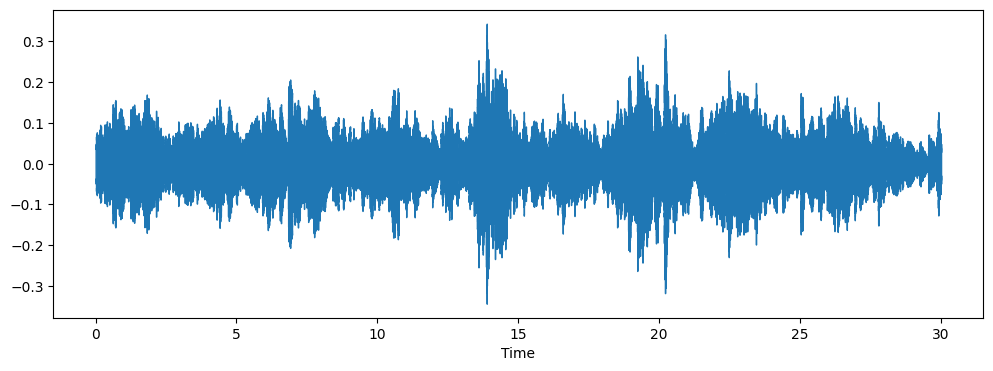

In [9]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio, sr=sr)
plt.show()

### 2. Spectrogram

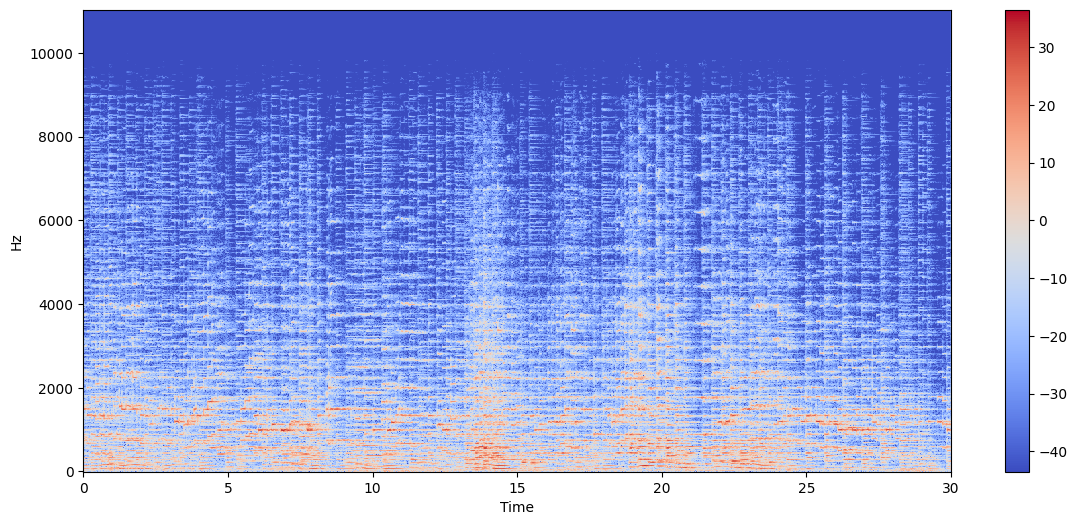

In [10]:
stft = librosa.stft(audio)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14, 6))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

### 3. Chroma Features

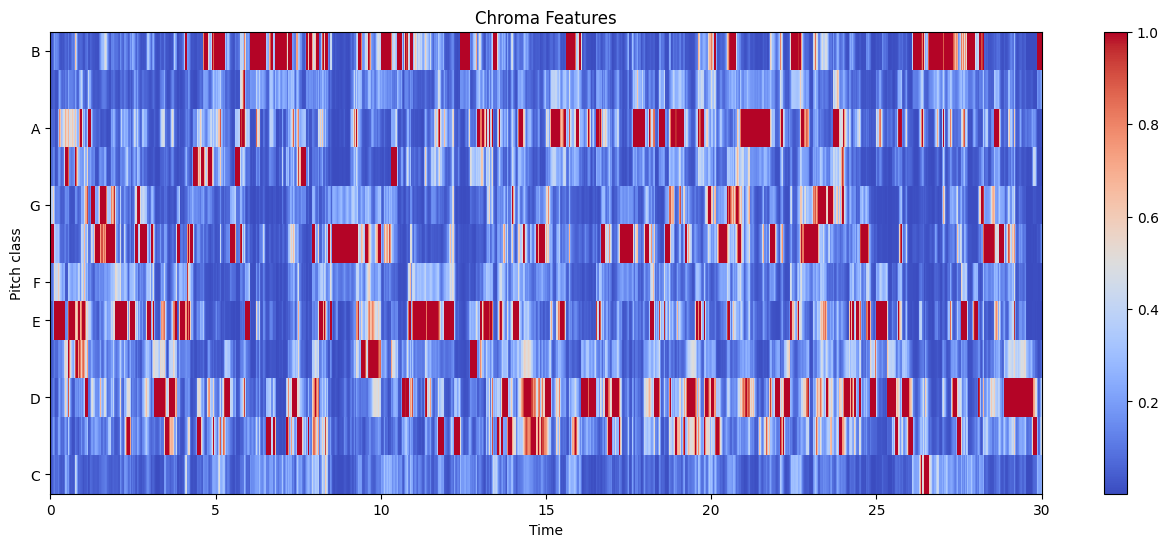

In [11]:
chroma = librosa.feature.chroma_stft(y = audio, sr=sr)
plt.figure(figsize=(16,6))
librosa.display.specshow(chroma, sr = sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

### 4. Zero Crossing rate

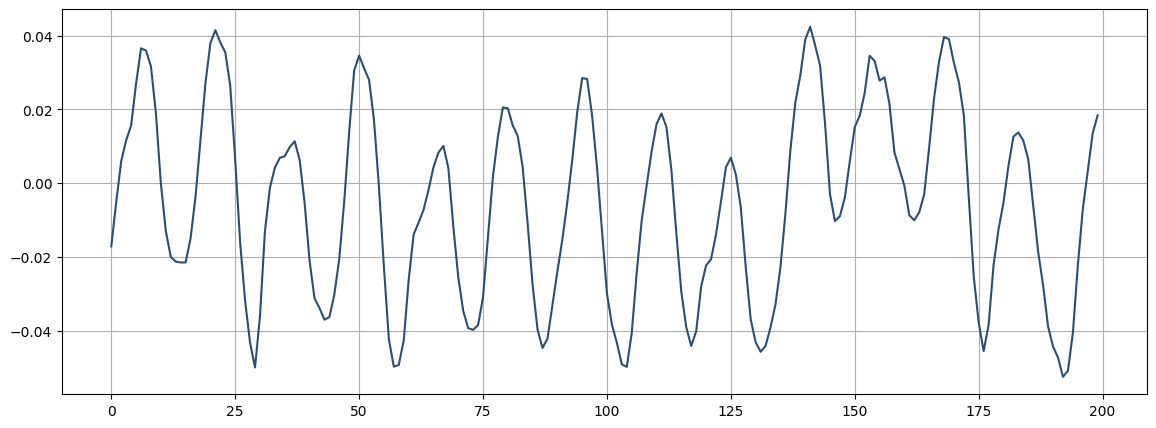

In [12]:
start = 1000
end = 1200
plt.figure(figsize=(14, 5))
plt.plot(audio[start:end], color="#2B4F72")
plt.grid()

## 5. MFCC Coefficients

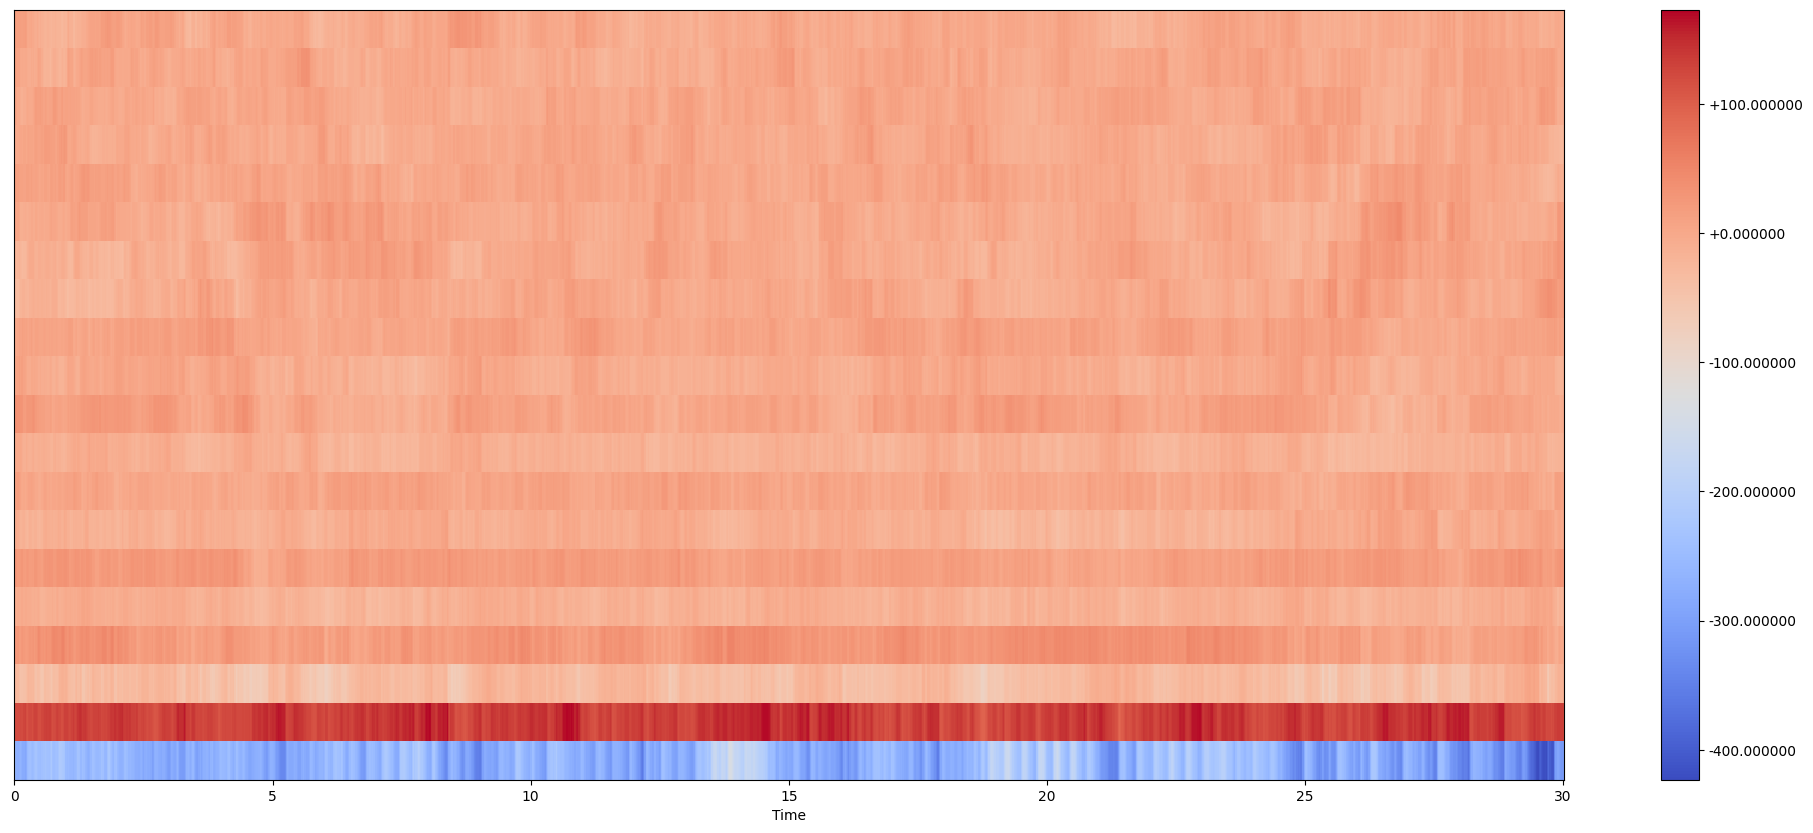

In [13]:
mfcc = librosa.feature.mfcc(y=audio, sr=sr)
plt.figure(figsize=(25, 10))
librosa.display. specshow(mfcc, x_axis="time", sr=sr)
plt.colorbar (format= "%+2f")
plt.show()

# Preprocessing the Data

### Dropping unwanted columns

In [14]:
df = df.drop(columns = ['filename','length','harmony_mean','harmony_var','perceptr_mean','perceptr_var'])

### Encoding labels

In [15]:
class_list = df.iloc[:, -1]
convertor = LabelEncoder()
class_list

0       blues
1       blues
2       blues
3       blues
4       blues
        ...  
9985     rock
9986     rock
9987     rock
9988     rock
9989     rock
Name: label, Length: 9990, dtype: object

In [16]:
y = convertor.fit_transform(class_list)
y

array([0, 0, 0, ..., 9, 9, 9])

### Scaling the Features

In [17]:
from sklearn.preprocessing import StandardScaler
fit = StandardScaler()
X = fit.fit_transform(np.array(df.iloc[:, :-1], dtype = float))
mean = fit.mean_
var = fit.var_
print(var)

[8.18323495e-03 9.28551851e-05 4.69800060e-03 1.28554416e-05
 5.65237792e+05 1.89175122e+11 2.95748054e+05 1.02708882e+10
 2.69610866e+06 2.21808498e+12 2.08382222e-03 1.30565117e-05
 1.08307001e+03 1.13318201e+04 6.73987475e+06 1.20210895e+03
 2.11307742e+05 5.74624291e+02 8.67042415e+04 3.16967053e+02
 1.77309427e+04 1.84091657e+02 1.19393023e+04 1.60070048e+02
 5.76029371e+03 1.22946919e+02 4.29462673e+03 1.23708906e+02
 2.10488066e+03 8.77585508e+01 2.00084204e+03 7.81653164e+01
 1.75243609e+03 6.11645480e+01 1.61735434e+03 5.71960755e+01
 1.40468572e+03 5.08610315e+01 1.27768715e+03 3.70147932e+01
 1.42232347e+03 3.51549458e+01 1.38757009e+03 3.28886462e+01
 1.18618884e+03 3.22294040e+01 1.32487610e+03 2.68433205e+01
 1.45734660e+03 2.61278761e+01 1.72919540e+03 2.75938021e+01
 2.15684889e+03]


## Dividing data into Training and Testing Sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

## Building and training the Model

In [21]:
from keras.models import Sequential
#from keras.wrappers scikit_learn import KerasClassifier
def trainModel(model, epochs, optimizer):
    batch_size = 128
    #callback = myCallback()
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,
    batch_size=batch_size)
               


In [22]:
def plotValidate(history):
    print("Validation Accuracy", max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [23]:
model = k.models.Sequential(
 [k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
 k.layers.Dropout (0.2),
 k.layers.Dense(256, activation='relu'),
 k.layers.Dropout (0.2),
 k.layers.Dense(128, activation='relu'),
 k.layers.Dropout (0.2),
 k.layers.Dense(64, activation='relu'),
 k.layers.Dropout (0.2),
 k.layers.Dense(10, activation='softmax'),])
print(model.summary())
model_history = trainModel(model=model, epochs=500, optimizer='adam')
print("Cell Ran")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        27,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,778 (784.29 KB)

 Trainable params: 200,778 (784.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/500
48/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2650 - loss: 1.9926

I0000 00:00:1713115852.106885      96 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713115852.121259      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3051 - loss: 1.8904

W0000 00:00:1713115860.232871      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713115860.920426      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.3066 - loss: 1.8866 - val_accuracy: 0.6547 - val_loss: 1.0576
Epoch 2/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5866 - loss: 1.1902 - val_accuracy: 0.7227 - val_loss: 0.8516
Epoch 3/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6702 - loss: 0.9689 - val_accuracy: 0.7698 - val_loss: 0.7125
Epoch 4/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7152 - loss: 0.8301 - val_accuracy: 0.7848 - val_loss: 0.6465
Epoch 5/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7457 - loss: 0.7565 - val_accuracy: 0.8118 - val_loss: 0.5990
Epoch 6/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7777 - loss: 0.6701 - val_accuracy: 0.8218 - val_loss: 0.5325
Epoch 7/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8088 - loss: 0.5770 - val_accuracy: 0.8278 - val_loss: 0.5331
Epoch 8/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8230 - loss: 0.5321 - val_accuracy: 0.8428 - val_loss: 

## Model Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9441 - loss: 0.4023 
The test Loss is : 0.5297325849533081
The test Accuracy is : 93.29329133033752
Validation Accuracy 0.9499499201774597


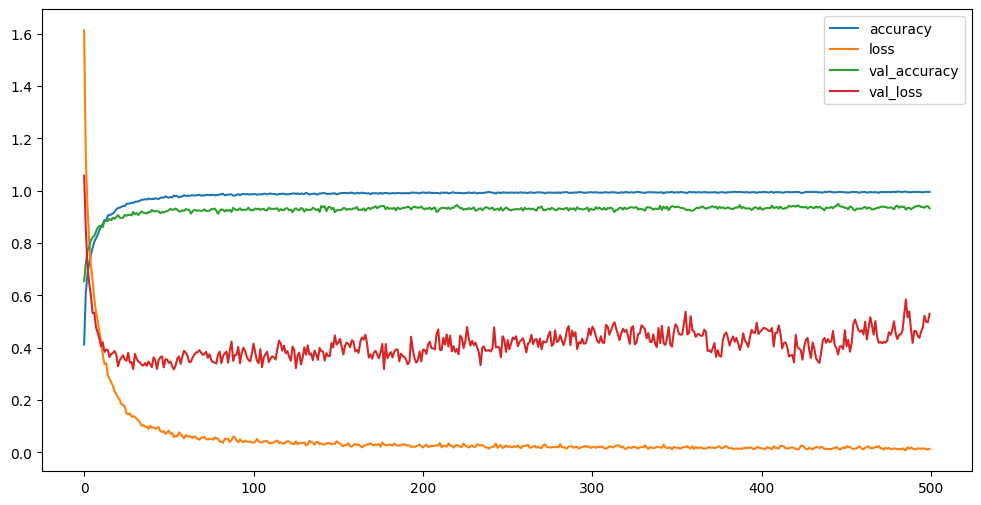

In [24]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("The test Accuracy is :",test_acc*100)
plotValidate(model_history)

# **Inference**

## Extracting features of inference input

In [59]:
def features_extract(y,sr):
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    tempo = librosa.feature.tempo(y=y,sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    
    features_list = [chroma_stft, rms,spec_cent,spec_bw,rolloff,zcr]
    features = []
    for e in features_list:
        features.append(np.mean(e))
        features.append(np.var(e))
        
    features.append(np.mean(tempo))
    
    for e in mfcc:
        features.append(np.mean(e))
        features.append(np.var(e))
    return features
##
##
songname = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/metal/metal.00020.wav'
y, sr = librosa.load(songname, duration = 3)
features = features_extract(y,sr)

print(features)
scaled_features = []

for i in range(0,len(features)):
    scaled_features.append((features[i] - mean[i])/var[i])

scaled_features
len(features)

[0.5398034, 0.0700063, 0.12287826, 0.00045511185, 2764.0795822864416, 226555.40121837103, 2381.928905643256, 56345.227358102435, 5546.8703049879805, 796131.3841626842, 0.16360426682692308, 0.0019696079908743417, 123.046875, -63.28924, 422.50107, 80.61795, 399.31723, -20.668251, 205.52002, 68.1828, 120.51645, -13.735021, 61.95707, 25.167946, 63.366405, -23.079466, 46.208908, 25.033026, 40.699085, -14.455886, 58.656055, 22.405476, 49.072712, -13.848954, 31.147133, 15.264195, 30.663237, -14.958374, 29.090822, 6.5705256, 28.470451, -10.753411, 25.407112, 6.2511215, 42.412685, -9.705494, 22.951487, 4.6488595, 26.2236, -5.71011, 21.903065, 3.7086513, 28.906725]


53

In [60]:
arr = np.array(scaled_features, dtype='float')
arr.shape
reshaped_data = tf.reshape(arr, (1, 53))
reshaped_data

<tf.Tensor: shape=(1, 53), dtype=float64, numpy=
array([[ 1.95850815e+01, -1.60140165e+02, -1.69876317e+00,
        -1.72788758e+02,  9.99331891e-04, -1.00498044e-06,
         4.75211739e-04, -6.02926294e-06,  3.63781226e-04,
        -3.75395260e-07,  2.92855023e+01, -4.98228651e+01,
        -1.69964496e-03,  7.24820910e-03, -3.54072326e-04,
        -1.69454554e-02, -8.96692766e-04, -1.85742880e-02,
        -1.94474453e-03,  9.76097520e-02, -3.57537804e-03,
        -6.36961059e-02, -6.85640104e-03,  6.10514581e-02,
        -7.71105990e-03, -1.40356768e-01, -1.21771364e-02,
         1.15322064e-01, -1.61985128e-02, -7.84659776e-02,
        -7.82333371e-03,  1.80665886e-01, -1.12593469e-02,
        -1.20082411e-01, -2.01969047e-02,  1.80569737e-01,
        -1.93119189e-02, -1.92133382e-01, -2.19455653e-02,
         1.19030692e-01, -1.79979408e-02, -1.87118475e-01,
        -1.96539040e-02,  1.46034630e-01, -6.38690015e-03,
        -1.70862233e-01, -2.18973431e-02,  1.45619718e-01,
       

### Genre Classification based on extracted features

In [61]:
result = model.predict(reshaped_data)
ind = np.argmax(result)
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
genres[ind]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


'metal'